In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
from scipy import stats
import warnings
import string
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
import re

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MatanD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [227]:
df = pd.read_csv('C:/Analytics/ItemMatching/PreProcess/food_fitcher_exploration.csv')
#rules = pd.read_csv('C:/Analytics/ItemMatching/PreProcess/new_rules_clean.csv')

In [228]:
#feeling the data 
headers = df.columns ## retrieving the dataset headers names
headers_list = list(headers) ## converting the pandas object to a list



In [229]:
regex_pool = [r'oz\b',r'btl\b',r'draft\b',r'g-\b',r'\bbtl\b',r'\bbtl']
#regex_pool = [r'btl\b']


In [230]:
regex_pool

['oz\\b', 'btl\\b', 'draft\\b', 'g-\\b', '\\bbtl\\b', '\\bbtl']

In [231]:
#checking if data is balanced
df.count()

bar_product_id     370793
title              370786
price              370793
category_id        370793
country_id         370793
brand_id           368001
super_brand_id     370793
volume_id          368001
beer_type_id       332420
serving_type_id    331916
train              370793
dtype: int64

In [232]:
virable = 'price'


In [233]:
def regex_rules(row,pool):
    for reg in pool:
        #print(row)
        #print('reg is ' +str(reg))
        val = re.sub(str(reg),'',str(row))
        #print(val)
        if row != val:
            #print('return ' +str(val) +'instead of ' +str(row))
            return(val)
        continue
    return(row)

In [234]:
#cleansing data function - turn words to lowercse, strip punctuation and numbers and remove nulls
def data_cleaner(df,column_name):
    df[column_name] = df[column_name].str.replace('[{}]'.format(string.punctuation+"0123456789"), '')
    df[column_name] = df[column_name].apply(lambda row : regex_rules(row,regex_pool))
    df[column_name]= df[column_name].str.lower()
    df = df.dropna(subset=[column_name])
    return(df)
#active function on each and every un-numerical virable 
df = data_cleaner(df,'title')

#aligning the data - make sure data is balanced
df = df.dropna(how='any')
df[virable] = df.price.astype(float)
df.count()

bar_product_id     331028
title              331028
price              331028
category_id        331028
country_id         331028
brand_id           331028
super_brand_id     331028
volume_id          331028
beer_type_id       331028
serving_type_id    331028
train              331028
dtype: int64

In [235]:
df.head()

bar_product_id                  title  price  category_id     country_id  \
0         1366032  goose island  growler  31.08            1         Canada   
1         1366042                 corona   3.75            1         Canada   
2         1366063       bulmers original  21.00            1      Australia   
3         1366116           anchor steam   6.46            1         Canada   
4         1366145          g rino deluxe   4.00            1  United States   

   brand_id  super_brand_id  volume_id  beer_type_id  serving_type_id  train  
0     395.0              10      1.419           6.0              2.0      1  
1     128.0              58      0.355           1.0              1.0      1  
2       6.0              63      0.560           5.0              2.0      1  
3     727.0              37      0.355           1.0              1.0      1  
4    4129.0               0      0.384           2.0              2.0      1

In [236]:
def Scaling(X_train):
    X_train = X_train.reshape(-1,1)
    scaler = StandardScaler() ##init
    scaler.fit(X_train) ## fit according to train data
    X_scaled = scaler.transform(X_train) ##transform trin
    return X_scaled

In [237]:
#cleaning virable by quantline (possible to do it also by stdv)
#q virable is the virable value that explaines x percent of the data
#this section gives relation between num of samples and covers level
def quantline_presentor(df):
    x = [0.5,0.75,0.80,0.85,0.9,0.92,0.95,0.96,0.98,0.9,0.99,0.999,0.99999,1.0]
    y=[]
    data=[]
    per=[]
    for i in x:
        q = df[virable].quantile(i)   #what is the price that covers 90% of the samples?
        y.append(q)
        data.append((i,q))
    gap=[0]    
    for tup in range(len(data)-1):
        rez =(data[tup][1],data[tup+1][1],data[tup+1][1]-data[tup][1])
        if rez[2]> max(gap):
            gap.append(data[tup-1][0])
    precentage=gap[-1]
    plt.scatter(x, y,alpha=0.8)
    plt.show()
    return(precentage)
    

In [238]:
#cleaning virable by quantline (possible to do it also by stdv)
#q virable is the virable value that explaines x percent of the data
def quantile_outlier_removal(df,percantge):
    print('percantge is '+ str(percantge))
    count_before_outliers = df[virable].count()
    q = df[virable].quantile(percantge)   #what is the price that covers x% of the data
    print('q is '+ str(q))
    df_1 =df[df[virable] < q]
    #cleaning negative prices
    df_2 =df_1[df_1[virable] >  0]
    count_after_outliers = df_2[virable].count()
    num_of_outliers = count_before_outliers- count_after_outliers
    per_of_outliers = (num_of_outliers/count_before_outliers)*100
    print('name of data '+str(df_2.country_id.iloc[0]))
    print('num of outliers '+str(num_of_outliers))
    print('outliers are '+str(per_of_outliers) +' percent from the whole data ')
    return(df_2)

In [239]:
#Separting data per countries
argentina_df= df[df.country_id=='Argentina']
australia_df= df[df.country_id=='Australia']
brazil_df= df[df.country_id=='Brazil']
canada_df= df[df.country_id=='Canada']
korea_df= df[df.country_id=='Korea']
uk_df= df[df.country_id=='United Kingdom']
us_df= df[df.country_id=='United States']
df_list=[argentina_df,australia_df,brazil_df,canada_df,korea_df,uk_df,us_df]




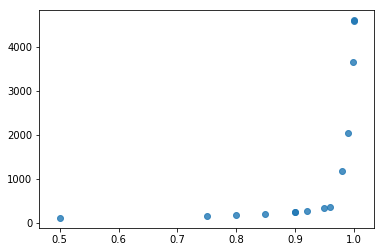

percantge is 0.999
q is 3662.345710000007
name of data Argentina
num of outliers 236
outliers are 1.984861227922624 percent from the whole data 
count    11654.000000
mean       175.168229
std        293.117232
min          0.010000
25%         85.000000
50%        120.000000
75%        170.000000
max       3661.390000
Name: price, dtype: float64


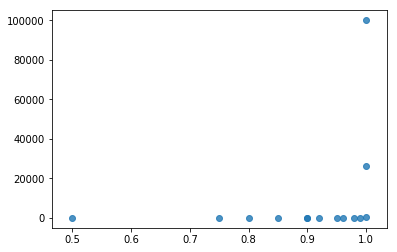

percantge is 0.999
q is 334.1950000000361
name of data Australia
num of outliers 4756
outliers are 5.788564056376427 percent from the whole data 
count    77406.000000
mean        18.841396
std         21.433893
min          0.100000
25%          6.200000
50%          9.500000
75%         21.500000
max        330.000000
Name: price, dtype: float64


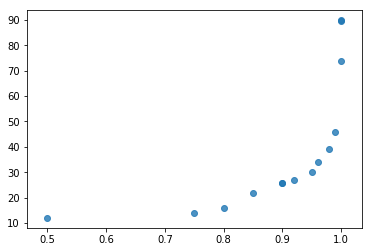

percantge is 0.99
q is 45.75500000000013
name of data Brazil
num of outliers 11
outliers are 1.3647642679900744 percent from the whole data 
count    795.000000
mean      13.582566
std        7.222322
min        0.010000
25%        9.300000
50%       12.000000
75%       13.900000
max       43.000000
Name: price, dtype: float64


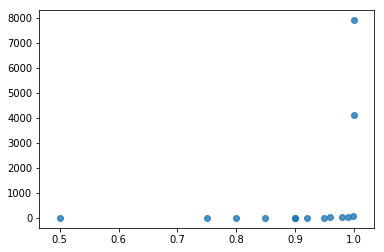

percantge is 0.999
q is 94.61609000001859
name of data Canada
num of outliers 7566
outliers are 7.426967174493482 percent from the whole data 
count    94306.000000
mean         8.970118
std          6.823955
min          0.010000
25%          5.000000
50%          6.830000
75%          9.740000
max         94.460000
Name: price, dtype: float64


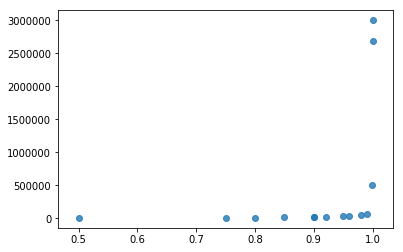

percantge is 0.999
q is 500000.0
name of data Korea
num of outliers 537
outliers are 2.355159861409587 percent from the whole data 
count     22264.000000
mean      10987.119340
std       17941.273972
min           1.000000
25%        5000.000000
50%        7000.000000
75%       10000.000000
max      420000.000000
Name: price, dtype: float64


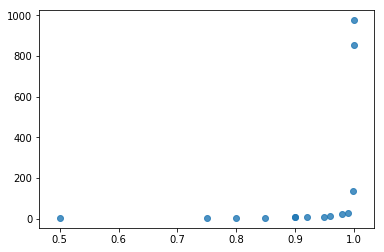

percantge is 0.999
q is 137.60700000007273
name of data United Kingdom
num of outliers 641
outliers are 3.0173225381284126 percent from the whole data 
count    20603.000000
mean         4.400375
std          5.384988
min          0.200000
25%          2.400000
50%          3.500000
75%          4.500000
max         99.000000
Name: price, dtype: float64


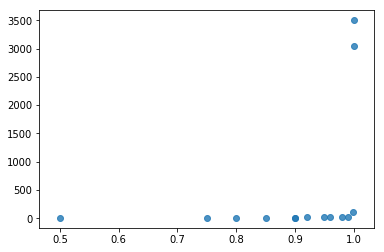

percantge is 0.999
q is 117.40484000004348
name of data United States
num of outliers 2867
outliers are 3.1766257077327067 percent from the whole data 
count    87386.000000
mean         7.625679
std          5.303656
min          0.010000
25%          5.000000
50%          6.250000
75%          8.000000
max        112.670000
Name: price, dtype: float64


In [240]:
new_df=[]
for df in df_list: 
#choose virable you want to explore  
    per = quantline_presentor(df)
    df =quantile_outlier_removal(df,per)
    #show virable distribution after outliers 
    print(df[virable].describe())
    df[virable]= Scaling(df.values[0:,2])
    new_df.append(df)
df = pd.concat(new_df)
    

In [241]:
df.head()

bar_product_id                  title     price  category_id country_id  \
79          1368095          cerveza negra -0.102926            1  Argentina   
89          1368418         stella artrois  0.033544            1  Argentina   
97          1368657  on stout cchoco pinta -0.290573            1  Argentina   
100         1368783  elefante jarrontirada  0.050602            1  Argentina   
233         1370633         quilmes tirada -0.409984            1  Argentina   

     brand_id  super_brand_id  volume_id  beer_type_id  serving_type_id  train  
79     1446.0               0       1.00           1.0              1.0      1  
89       44.0               5       0.33           1.0              2.0      1  
97     3009.0               0       0.50           6.0              2.0      1  
100    1301.0               0       1.00           1.0              2.0      1  
233    1301.0               0       0.33           1.0              2.0      1

In [242]:
def word_counter(df):
    print('name of data '+str(df.country_id.iloc[0]))
    corpus = df.title.values
    print('num of titles '+str(len(corpus)))
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    print('num of unique word '+str(len(vectorizer.get_feature_names())))
    words = np.asarray(vectorizer.get_feature_names()).reshape(len(vectorizer.get_feature_names()),1)
    word_counter = np.asarray(X.sum(axis=0))
    word_counter = np.transpose(word_counter)
    stack = np.stack((words, word_counter), axis=1).reshape([len(vectorizer.get_feature_names()), 2])
    temp_df = pd.DataFrame(stack,columns=['words','counter'])
    sort_temp_df = temp_df.sort_values(by=['counter'],ascending=False)
    print(sort_temp_df.head(5))
    print(''.join('')+'\n')
    return()

In [243]:
for df in df_list: 
    word_counter(df)

name of data Argentina
num of titles 11890
num of unique word 907
          words counter
617       patag      96
222          cm      91
388    heineken      90
141          bz       9
51   bacodeitor       9


name of data Australia
num of titles 82162
num of unique word 4143
        words counter
3169      sch     991
2845   plight      99
1069     dght      99
501     brown      99
1328  fosters      99


name of data Brazil
num of titles 806
num of unique word 285
       words counter
59     chopp      90
82        de       9
166       ln       9
53   cerveja      85
171     long      84


name of data Canada
num of titles 101872
num of unique word 7159
        words counter
3925      lrg     994
1458    cider     983
3977  magners      98
5962       sl      97
6393      sun      97


name of data Korea
num of titles 22801
num of unique word 1455
       words counter
1085      ¼ì     953
1264      ìˆ      90
439      ice       9
587   monaco       9
367    grape       9


name of 

In [271]:
#returning bigrams counter for the 
def bigrams_counter(df):
    #print('name of data '+str(df.country_id.iloc[0]))
    sent = ''.join(df.title.values)
    nltk_tokens = nltk.word_tokenize(sent)  	
    curr_bigrams = list(nltk.bigrams(nltk_tokens))
    curr_df = pd.DataFrame(curr_bigrams, columns=['word_a', 'word_b'])
    curr_df = curr_df.groupby(curr_df.columns.tolist()).size().reset_index().rename(columns={0:'count'})
    curr_df = curr_df.sort_values(by=['count'],ascending=False)
    temp = curr_df.head(15)
    temp['country'] = pd.Series(str(df.country_id.iloc[0]), index=temp.index)
    lst.append(temp)
    #print(curr_df.head(15))
    return()

In [272]:
exec_df = pd.DataFrame(columns=['word_a','word_b','count'])
lst=[]
for df in df_list: 
    bigrams_counter(df)

In [277]:
final = pd.concat(lst)
final.to_csv('beer_bigrams', sep='\t', encoding='utf-8')

word_a      word_b  count         country
11216         stella      artois    108       Argentina
8097       patagonia       amber     72       Argentina
804           artois       noire     70       Argentina
3022              ch           y     60       Argentina
2823        ccstella      artois     59       Argentina
185            amber       lager     56       Argentina
6338     litrostella      artois     41       Argentina
7087           media       pinta     36       Argentina
6993        ltstella      artois     35       Argentina
8137       patagonia    bohemian     30       Argentina
10842  quilmesstella      artois     30       Argentina
2066         burguer       doble     28       Argentina
8313       patagonia      weisse     27       Argentina
2794       ccquilmes       stout     27       Argentina
6858       ltsbarril   patagonia     27       Argentina
53470           pale         ale   1382       Australia
211              ale         btl    840       Australia
77660          super         dry    676       Australia
37655          lager         btl    659       Australia
13063            can          pk    652       Australia
25477            dry         btl    579       Australia
82112       xmlgreat       north    517       Australia
11296            btl  xmlcarlton    508       Australia
11622            btl     xmlxxxx    484       Australia
49682          north         org    427       Australia
83691            yak        pale    425       Australia
73908           stub         ctn    407       Australia
10834            btl         ctn    398       Australia
29981           gold         can    398       Australia
62286           prem       light    395       Australia
...              ...         ...    ...             ...
16613           pale         ale     82  United Kingdom
20237        pintsan      miguel     47  United Kingdom
6121            dark       fruit     44  United Kingdom
19427       pintjohn      smiths     35  United Kingdom
22813        session         ipa     31  United Kingdom
12505         island           d     31  United Kingdom
19834        pintold        mout     31  United Kingdom
15648           mout        kiwi     29  United Kingdom
2261             big        wave     26  United Kingdom
20471  pintstrongbow        dark     25  United Kingdom
10256      halfnorth           x     25  United Kingdom
8660            half        pint     25  United Kingdom
241              ale        half     24  United Kingdom
6145            dark      fruits     24  United Kingdom
25206          table        beer     23  United Kingdom
36051            ipa         big   1196   United States
8429             big    daddysam   1177   United States
8048             big    daddybud    980   United States
81063             xx       amber    811   United States
47114             lt         big    782   United States
21307       daddysam       adams    730   United States
54207        orchard       cider    675   United States
8145             big    daddydos    650   United States
20296       daddydos          xx    606   United States
24484       draftdos          xx    599   United States
25646       draftsam       adams    572   United States
60871     pitchersam       adams    569   United States
55738           pale         ale    568   United States
29262           four        star    548   United States
39481         island        four    544   United States

[105 rows x 4 columns]

In [257]:
lst = ['ausi']*8

In [258]:
lst

['ausi', 'ausi', 'ausi', 'ausi', 'ausi', 'ausi', 'ausi', 'ausi']